In [904]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np

In [905]:
random_state_value = 42

def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

In [906]:
def clean_data(data):
    data.dropna(inplace=True)
    data = data.drop(['Unnamed: 0', 'Sex'], axis=1)
    return data

In [907]:
def preprocess_data(X, y):
    y_numeric = y.str.extract('(\d+)').astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_numeric, test_size=0.2, random_state=random_state_value)
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train), columns=X_train.columns)
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test), columns=X_test.columns)
    k_neighbors_value = min(5, len(X_train) - 1)

    smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors_value, random_state=random_state_value)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)
    
    return X_train_resampled, X_test_imputed, y_train_resampled.values.ravel(), y_test.values.ravel()


In [908]:
from sklearn.metrics import roc_curve, auc

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix'

    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [909]:
PRINT_AUC = True

def train_and_evaluate_ml(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    print("\nClassification Report:")
    print(classification_report(y_test, predictions, zero_division=1))

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(y_test, predictions, classes=np.unique(y_test), normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    roc_auc = None
    
    # AUC-ROC Curve Plot
    y_prob = classifier.predict_proba(X_test)  # Assuming the classifier has a predict_proba method
    n_classes = len(np.unique(y_test))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot AUC-ROC curve
    plt.figure(figsize=(6, 4))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, precision, recall, f1, roc_auc


In [910]:
def train_and_evaluate_ml_before(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    print("\nClassification Report:")
    print(classification_report(y_test, predictions, zero_division=1))

    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(y_test, predictions, classes=np.unique(y_test), normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1



In [911]:
def train_and_evaluate_nn(model, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred_prob = model.predict(X_test)
    y_pred = y_pred_prob.argmax(axis=1)
    
    # Accuracy, Precision, Recall, F1 Score
    print("Neural Network Accuracy:", accuracy_score(y_test, y_pred))
    print("Neural Network Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Neural Network Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("Neural Network F1 Score:", f1_score(y_test, y_pred, average='weighted'))

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Classification Report
    print("\nNeural Network Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(y_test, y_pred, classes=np.unique(y_test), normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    # AUC-ROC Curve Plot
    num_classes = len(np.unique(y_train))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot AUC-ROC curve
    plt.figure(figsize=(6, 4))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, precision, recall, f1, roc_auc



In [912]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


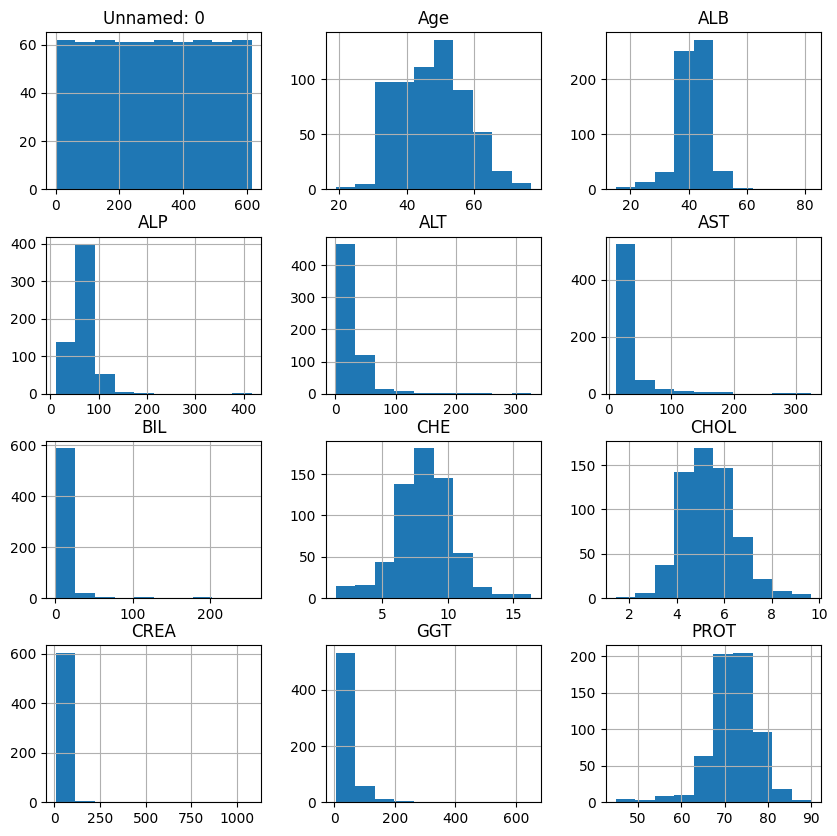

In [913]:
file_path = "hcvdat0.csv"
data = load_data(file_path)

data.hist(figsize=(10,10))
plt.plot()
cleaned_data = clean_data(data)
X = cleaned_data.drop('Category', axis=1)
y = cleaned_data['Category']


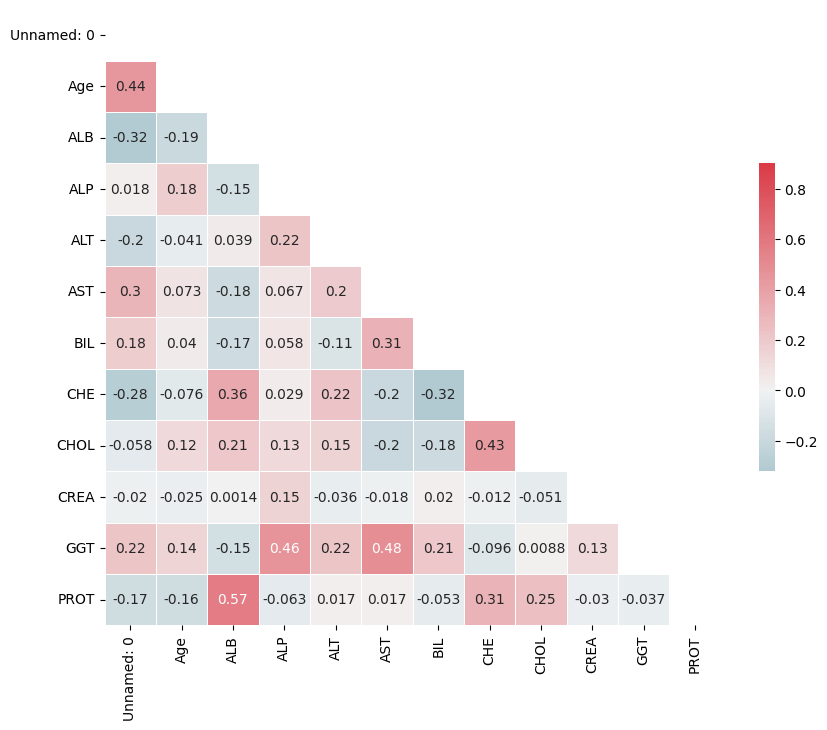

In [914]:

numeric_data = data.select_dtypes(include=np.number)

# Calculate correlation matrix
corr = numeric_data.corr()

# Create a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()



KNN Classifier (Before Preprocessing):
Accuracy: 0.8983050847457628
Precision: 0.8398146681450973
Recall: 0.8983050847457628
F1 Score: 0.8671539913106475

Classification Report:
                        precision    recall  f1-score   support

         0=Blood Donor       0.93      1.00      0.96        99
0s=suspect Blood Donor       1.00      0.00      0.00         2
           1=Hepatitis       0.00      0.00      1.00         8
            2=Fibrosis       0.50      0.67      0.57         3
           3=Cirrhosis       1.00      0.83      0.91         6

              accuracy                           0.90       118
             macro avg       0.69      0.50      0.69       118
          weighted avg       0.86      0.90      0.93       118



C:\Users\pande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


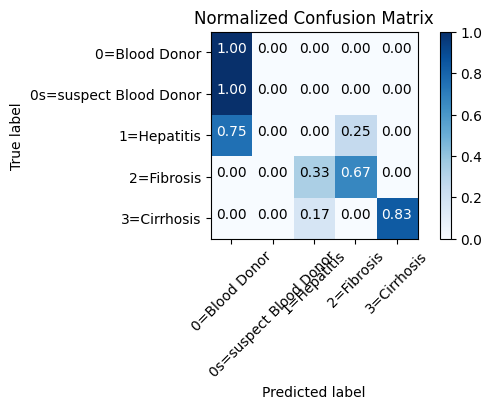

In [915]:
print("\nKNN Classifier (Before Preprocessing):")
knn_classifier = KNeighborsClassifier(n_neighbors=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_value)

knn_accuracy_before, knn_precision_before, knn_recall_before, knn_f1_before = train_and_evaluate_ml_before(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)




Decision Tree Classifier (Before Preprocessing):
Accuracy: 0.8813559322033898
Precision: 0.8595147981851948
Recall: 0.8813559322033898
F1 Score: 0.8674269121827436

Classification Report:
                        precision    recall  f1-score   support

         0=Blood Donor       0.95      0.99      0.97        99
0s=suspect Blood Donor       1.00      0.50      0.67         2
           1=Hepatitis       0.00      0.00      1.00         8
            2=Fibrosis       0.14      0.33      0.20         3
           3=Cirrhosis       0.80      0.67      0.73         6

              accuracy                           0.88       118
             macro avg       0.58      0.50      0.71       118
          weighted avg       0.86      0.88      0.94       118



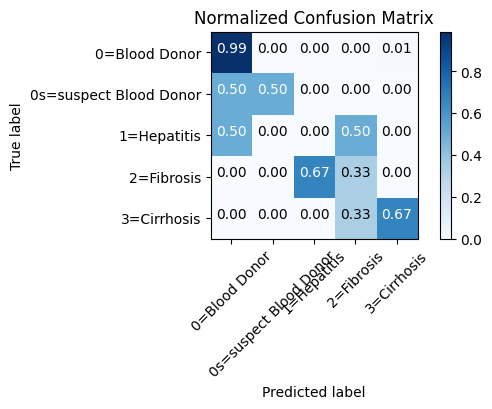

In [916]:
print("\nDecision Tree Classifier (Before Preprocessing):")
dt_classifier = DecisionTreeClassifier(random_state=random_state_value)
dt_accuracy_before, dt_precision_before, dt_recall_before, dt_f1_before = train_and_evaluate_ml_before(DecisionTreeClassifier(random_state=random_state_value), X_train, X_test, y_train, y_test)





Random Forest Classifier (Before Preprocessing):
Accuracy: 0.8898305084745762
Precision: 0.864646626159258
Recall: 0.8898305084745762
F1 Score: 0.8727711175416839

Classification Report:
                        precision    recall  f1-score   support

         0=Blood Donor       0.92      0.99      0.96        99
0s=suspect Blood Donor       0.50      0.50      0.50         2
           1=Hepatitis       0.25      0.12      0.17         8
            2=Fibrosis       0.50      0.33      0.40         3
           3=Cirrhosis       1.00      0.67      0.80         6

              accuracy                           0.89       118
             macro avg       0.63      0.52      0.56       118
          weighted avg       0.86      0.89      0.87       118



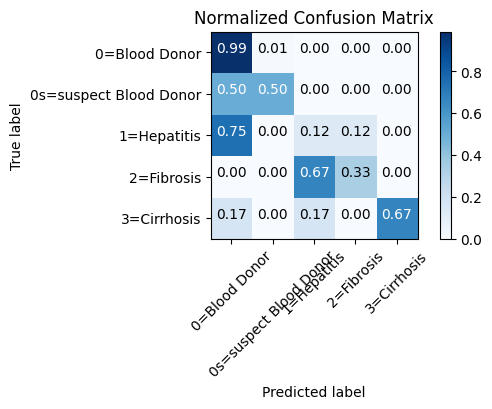

In [917]:


print("\nRandom Forest Classifier (Before Preprocessing):")
rf_classifier = RandomForestClassifier(random_state=random_state_value)
rf_accuracy_before, rf_precision_before, rf_recall_before, rf_f1_before = train_and_evaluate_ml_before(rf_classifier, X_train, X_test, y_train, y_test)





SVM Classifier (Before Preprocessing):
Accuracy: 0.8813559322033898
Precision: 0.8315957787016308
Recall: 0.8813559322033898
F1 Score: 0.8549527776894457

Classification Report:
                        precision    recall  f1-score   support

         0=Blood Donor       0.92      0.99      0.96        99
0s=suspect Blood Donor       0.00      0.00      1.00         2
           1=Hepatitis       0.20      0.12      0.15         8
            2=Fibrosis       1.00      0.00      0.00         3
           3=Cirrhosis       0.83      0.83      0.83         6

              accuracy                           0.88       118
             macro avg       0.59      0.39      0.59       118
          weighted avg       0.86      0.88      0.87       118



C:\Users\pande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


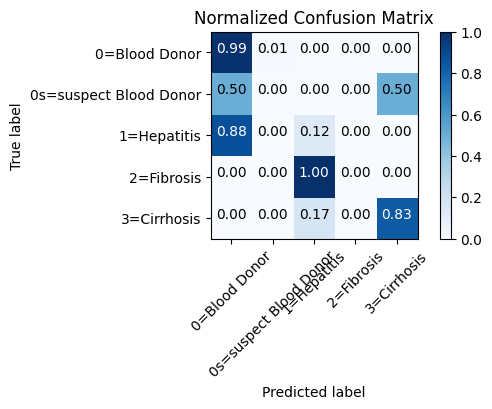

In [918]:
print("\nSVM Classifier (Before Preprocessing):")
svm_classifier = SVC(probability=True)
svm_accuracy_before, svm_precision_before, svm_recall_before, svm_f1_before = train_and_evaluate_ml_before(svm_classifier, X_train, X_test, y_train, y_test)
# ...



Neural Network (Before Preprocessing):
4/4 [==============================] - 0s 2ms/step
Neural Network Accuracy: 0.940677966101695
Neural Network Precision: 0.9586864406779662
Neural Network Recall: 0.940677966101695
Neural Network F1 Score: 0.9414483821263483

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       101
           1       0.75      0.38      0.50         8
           2       0.38      1.00      0.55         3
           3       1.00      0.83      0.91         6

    accuracy                           0.94       118
   macro avg       0.78      0.80      0.74       118
weighted avg       0.96      0.94      0.94       118



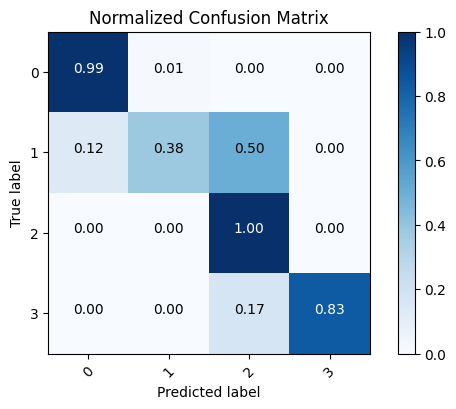

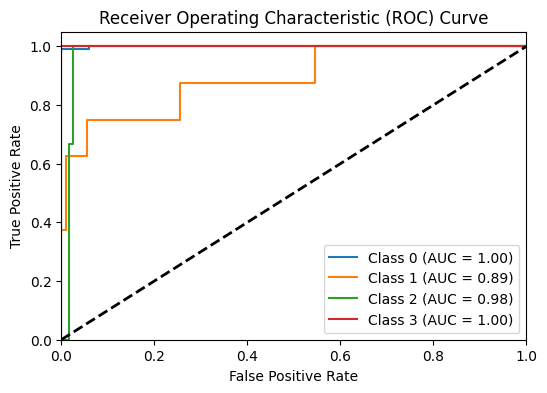

In [919]:
# nn before preprocessing
print("\nNeural Network (Before Preprocessing):")
X_train_resampled, X_test_imputed, y_train_resampled, y_test = preprocess_data(X, y)
num_classes = len(np.unique(y_train_resampled))
input_shape = (X_train_resampled.shape[1], 1)
X_train_reshaped = X_train_resampled.values.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_reshaped = X_test_imputed.values.reshape(X_test_imputed.shape[0], X_test_imputed.shape[1], 1)
model = build_cnn_model(input_shape, num_classes)

nn_accuracy_before, nn_precision_before, nn_recall_before, nn_f1_before, nn_roc_auc_before = train_and_evaluate_nn(model, X_train_reshaped, y_train_resampled, X_test_reshaped, y_test, epochs=20, batch_size=32)

In [920]:
def train_and_evaluate_cnn(model, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred_prob = model.predict(X_test)
    y_pred = y_pred_prob.argmax(axis=1)
    
    # Accuracy, Precision, Recall, F1 Score
    print("Neural Network Accuracy:", accuracy_score(y_test, y_pred))
    print("Neural Network Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Neural Network Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("Neural Network F1 Score:", f1_score(y_test, y_pred, average='weighted'))

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Classification Report
    print("\nNeural Network Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(y_test, y_pred, classes=np.unique(y_test), normalize=True, title='Normalized Confusion Matrix', cmap=plt.cm.Blues)
    plt.show()

    # AUC-ROC Curve Plot
    num_classes = len(np.unique(y_train))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot AUC-ROC curve
    plt.figure(figsize=(6, 4))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, precision, recall, f1, roc_auc


CNN (Before Preprocessing):
4/4 [==============================] - 0s 2ms/step
Neural Network Accuracy: 0.940677966101695
Neural Network Precision: 0.9539951573849879
Neural Network Recall: 0.940677966101695
Neural Network F1 Score: 0.9456779661016949

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       101
           1       0.57      0.50      0.53         8
           2       0.33      0.67      0.44         3
           3       1.00      1.00      1.00         6

    accuracy                           0.94       118
   macro avg       0.73      0.79      0.74       118
weighted avg       0.95      0.94      0.95       118



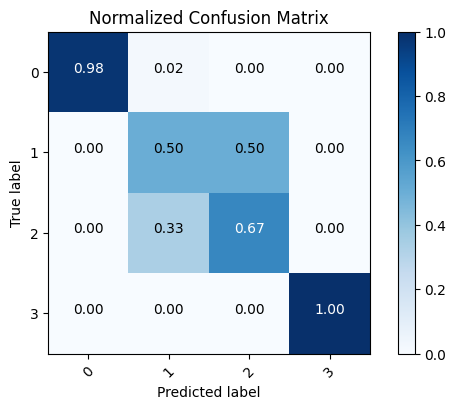

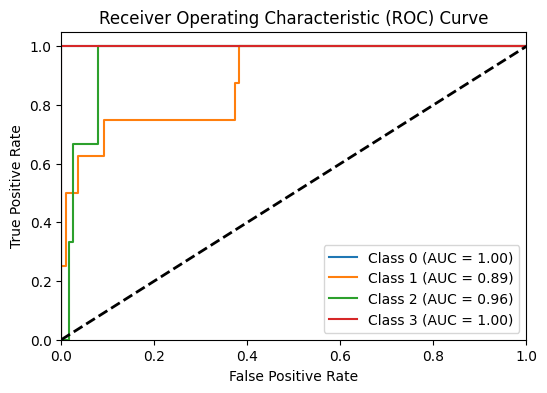

In [921]:
#cnn before
print("\nCNN (Before Preprocessing):")
X_train_resampled, X_test_imputed, y_train_resampled, y_test = preprocess_data(X, y)
num_classes = len(np.unique(y_train_resampled))
input_shape = (X_train_resampled.shape[1], 1)
X_train_reshaped = X_train_resampled.values.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_reshaped = X_test_imputed.values.reshape(X_test_imputed.shape[0], X_test_imputed.shape[1], 1)
model = build_cnn_model(input_shape, num_classes)

cnn_accuracy_before, cnn_precision_before, cnn_recall_before, cnn_f1_before, cnn_roc_auc_before = train_and_evaluate_cnn(model, X_train_reshaped, y_train_resampled, X_test_reshaped, y_test, epochs=20, batch_size=32)

In [922]:
X_train, X_test, y_train, y_test = preprocess_data(X, y)


KNN Classifier (After Preprocessing):
Accuracy: 0.923728813559322
Precision: 0.9337271015237117
Recall: 0.923728813559322
F1 Score: 0.9277966101694916

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       101
           1       0.50      0.50      0.50         8
           2       0.40      0.67      0.50         3
           3       0.83      0.83      0.83         6

    accuracy                           0.92       118
   macro avg       0.68      0.74      0.70       118
weighted avg       0.93      0.92      0.93       118



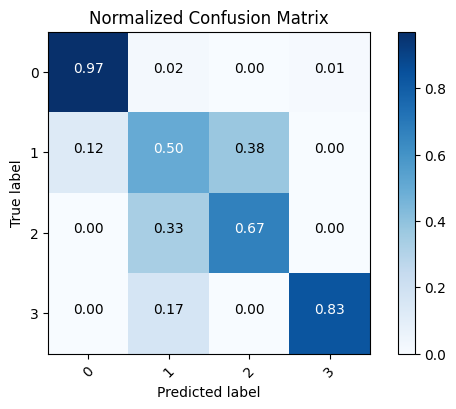

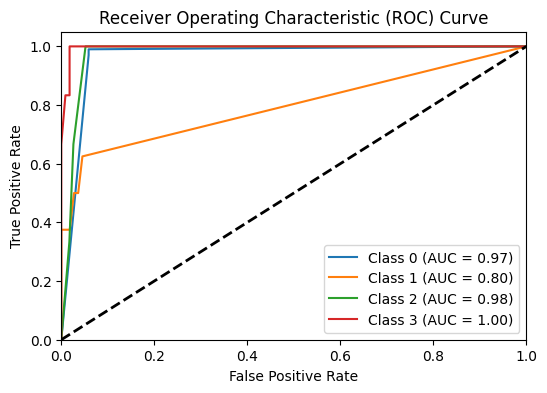

In [923]:
print("\nKNN Classifier (After Preprocessing):")
# Assuming PRINT_AUC is set to True for these evaluations
knn_accuracy_after, knn_precision_after, knn_recall_after, knn_f1_after, _ = train_and_evaluate_ml(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)




Decision Tree Classifier (After Preprocessing):
Accuracy: 0.8983050847457628
Precision: 0.9259391738205297
Recall: 0.8983050847457628
F1 Score: 0.9077760657421674

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       101
           1       0.57      0.50      0.53         8
           2       0.25      0.67      0.36         3
           3       1.00      0.67      0.80         6

    accuracy                           0.90       118
   macro avg       0.70      0.70      0.66       118
weighted avg       0.93      0.90      0.91       118



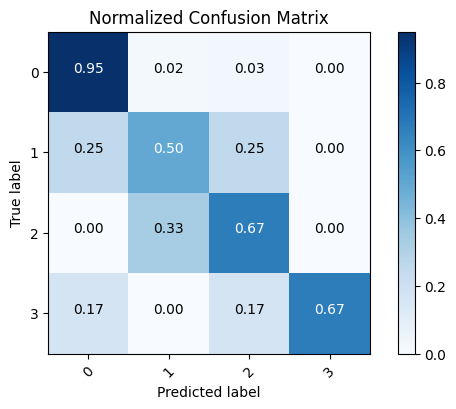

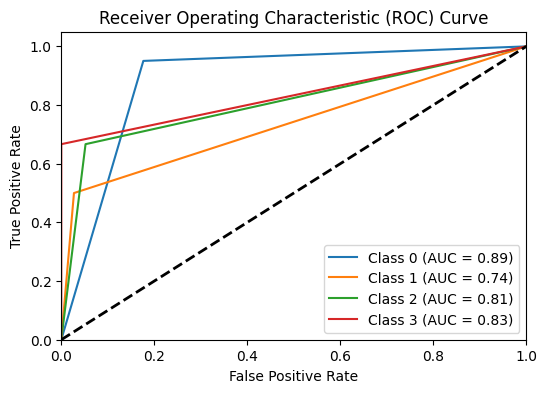

In [924]:
print("\nDecision Tree Classifier (After Preprocessing):")
dt_accuracy_after, dt_precision_after, dt_recall_after, dt_f1_after, _ = train_and_evaluate_ml(DecisionTreeClassifier(random_state=random_state_value), X_train, X_test, y_train, y_test)



Random Forest Classifier (After Preprocessing):
Accuracy: 0.9491525423728814
Precision: 0.9545663978936976
Recall: 0.9491525423728814
F1 Score: 0.9481985279592459

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       101
           1       0.80      0.50      0.62         8
           2       0.40      0.67      0.50         3
           3       1.00      0.83      0.91         6

    accuracy                           0.95       118
   macro avg       0.80      0.75      0.75       118
weighted avg       0.95      0.95      0.95       118



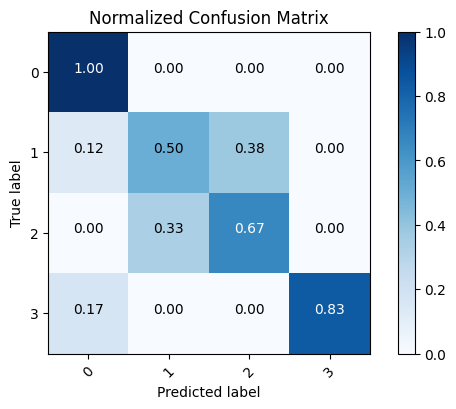

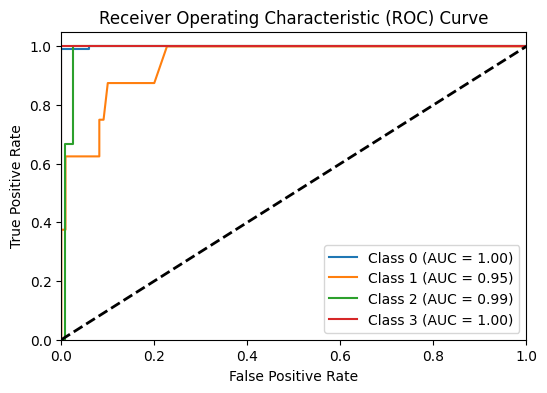

In [925]:
print("\nRandom Forest Classifier (After Preprocessing):")
rf_accuracy_after, rf_precision_after, rf_recall_after, rf_f1_after, _ = train_and_evaluate_ml(RandomForestClassifier(random_state=random_state_value), X_train, X_test, y_train, y_test)



SVM Classifier (After Preprocessing):
Accuracy: 0.9576271186440678
Precision: 0.9782082324455206
Recall: 0.9576271186440678
F1 Score: 0.9617144719687092

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       101
           1       1.00      0.62      0.77         8
           2       0.43      1.00      0.60         3
           3       0.86      1.00      0.92         6

    accuracy                           0.96       118
   macro avg       0.82      0.90      0.82       118
weighted avg       0.98      0.96      0.96       118



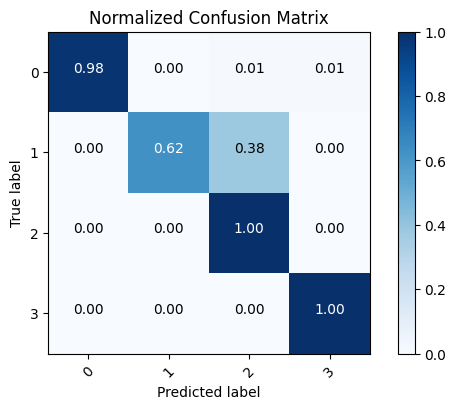

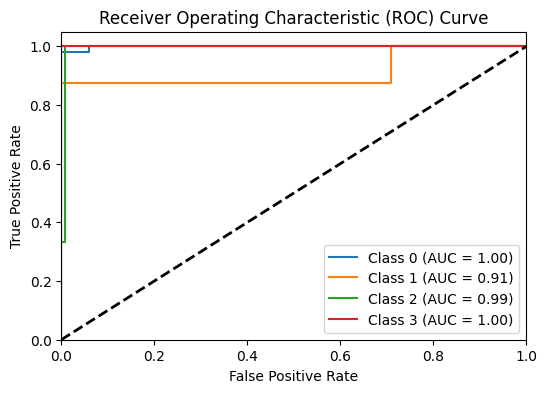

In [926]:
print("\nSVM Classifier (After Preprocessing):")
svm_accuracy_after, svm_precision_after, svm_recall_after, svm_f1_after, _ = train_and_evaluate_ml(SVC(probability=True), X_train, X_test, y_train, y_test)



Neural Network Classifier (After Preprocessing):
4/4 [==============================] - 0s 1ms/step
Neural Network Accuracy: 0.9745762711864406
Neural Network Precision: 0.9872881355932204
Neural Network Recall: 0.9745762711864406
Neural Network F1 Score: 0.9758800521512386

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.62      0.77         8
           2       0.50      1.00      0.67         3
           3       1.00      1.00      1.00         6

    accuracy                           0.97       118
   macro avg       0.88      0.91      0.86       118
weighted avg       0.99      0.97      0.98       118



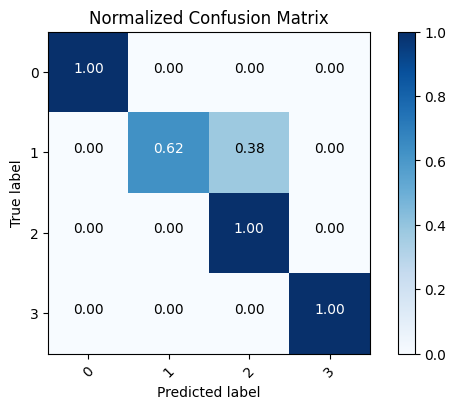

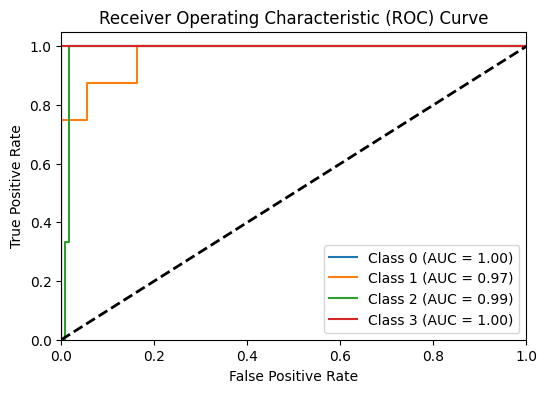

In [927]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = preprocess_data(X, y)

print("\nNeural Network Classifier (After Preprocessing):")
model_nn = Sequential()
model_nn.add(Dense(128, input_dim=X_train_nn.shape[1], activation='relu'))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(num_classes, activation='softmax'))  
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Assuming you have the nn and cnn values, replace them with the actual values
nn_accuracy_after, nn_precision_after, nn_recall_after, nn_f1_after, nn_roc_auc_after = train_and_evaluate_nn(model_nn, X_train_nn, y_train_nn, X_test_nn, y_test_nn)



CNN Classifier (After Preprocessing):
4/4 [==============================] - 0s 2ms/step
Neural Network Accuracy: 0.9661016949152542
Neural Network Precision: 0.9854721549636805
Neural Network Recall: 0.9661016949152542
Neural Network F1 Score: 0.9695626407490815

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.62      0.77         8
           2       0.43      1.00      0.60         3
           3       1.00      0.83      0.91         6

    accuracy                           0.97       118
   macro avg       0.86      0.86      0.82       118
weighted avg       0.99      0.97      0.97       118



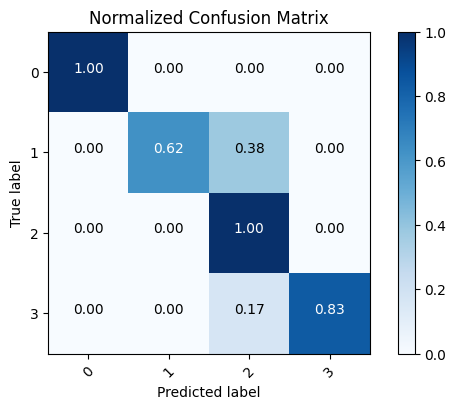

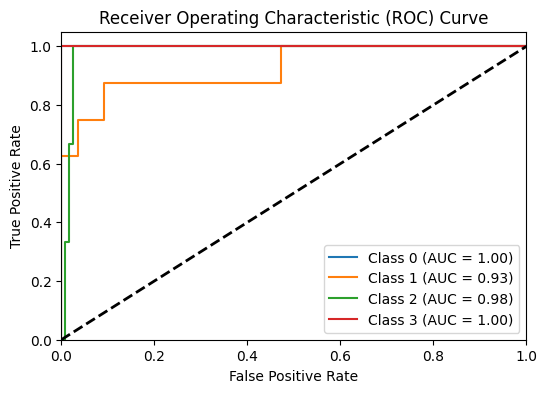

In [928]:
input_shape_cnn = (X_train_nn.shape[1], 1) 
X_train_nn_cnn = X_train_nn.values.reshape(X_train_nn.shape[0], X_train_nn.shape[1], 1)
X_test_nn_cnn = X_test_nn.values.reshape(X_test_nn.shape[0], X_test_nn.shape[1], 1)

print("\nCNN Classifier (After Preprocessing):")
cnn_model_after = build_cnn_model(input_shape_cnn, num_classes)
cnn_accuracy_after, cnn_precision_after, cnn_recall_after, cnn_f1_after, _ = train_and_evaluate_nn(cnn_model_after, X_train_nn_cnn, y_train_nn, X_test_nn_cnn, y_test_nn)


In [929]:
# make graphs to campare
accuracy_values_before = [knn_accuracy_before, dt_accuracy_before, rf_accuracy_before, svm_accuracy_before]
accuracy_values_after = [knn_accuracy_after, dt_accuracy_after, rf_accuracy_after, svm_accuracy_after]


precision_values_before = [knn_precision_before, dt_precision_before, rf_precision_before, svm_precision_before]
precision_values_after = [knn_precision_after, dt_precision_after, rf_precision_after, svm_precision_after]


recall_values_before = [knn_recall_before, dt_recall_before, rf_recall_before, svm_recall_before]
recall_values_after = [knn_recall_after, dt_recall_after, rf_recall_after, svm_recall_after]


f1_values_before = [knn_f1_before, dt_f1_before, rf_f1_before, svm_f1_before]
f1_values_after = [knn_f1_after, dt_f1_after, rf_f1_after, svm_f1_after]


accuracy_values_after += [nn_accuracy_after, cnn_accuracy_after]
precision_values_after += [nn_precision_after, cnn_precision_after]
recall_values_after += [nn_recall_after, cnn_recall_after]
f1_values_after += [nn_f1_after, cnn_f1_after]



Before Preprocessing:
KNN:
  Accuracy: 0.8983
  Precision: 0.8398
  Recall: 0.8983
  F1 Score: 0.8672

Decision Tree:
  Accuracy: 0.8814
  Precision: 0.8595
  Recall: 0.8814
  F1 Score: 0.8674

Random Forest:
  Accuracy: 0.8898
  Precision: 0.8646
  Recall: 0.8898
  F1 Score: 0.8728

SVM:
  Accuracy: 0.8814
  Precision: 0.8316
  Recall: 0.8814
  F1 Score: 0.8550

Neural Network:
  Accuracy: 0.9407
  Precision: 0.9587
  Recall: 0.9407
  F1 Score: 0.9414

CNN:
  Accuracy: 0.9407
  Precision: 0.9540
  Recall: 0.9407
  F1 Score: 0.9457

After Preprocessing:
KNN:
  Accuracy: 0.9237
  Precision: 0.9337
  Recall: 0.9237
  F1 Score: 0.9278

Decision Tree:
  Accuracy: 0.8983
  Precision: 0.9259
  Recall: 0.8983
  F1 Score: 0.9078

Random Forest:
  Accuracy: 0.9492
  Precision: 0.9546
  Recall: 0.9492
  F1 Score: 0.9482

SVM:
  Accuracy: 0.9576
  Precision: 0.9782
  Recall: 0.9576
  F1 Score: 0.9617

Neural Network:
  Accuracy: 0.9746
  Precision: 0.9873
  Recall: 0.9746
  F1 Score: 0.9759

CNN:

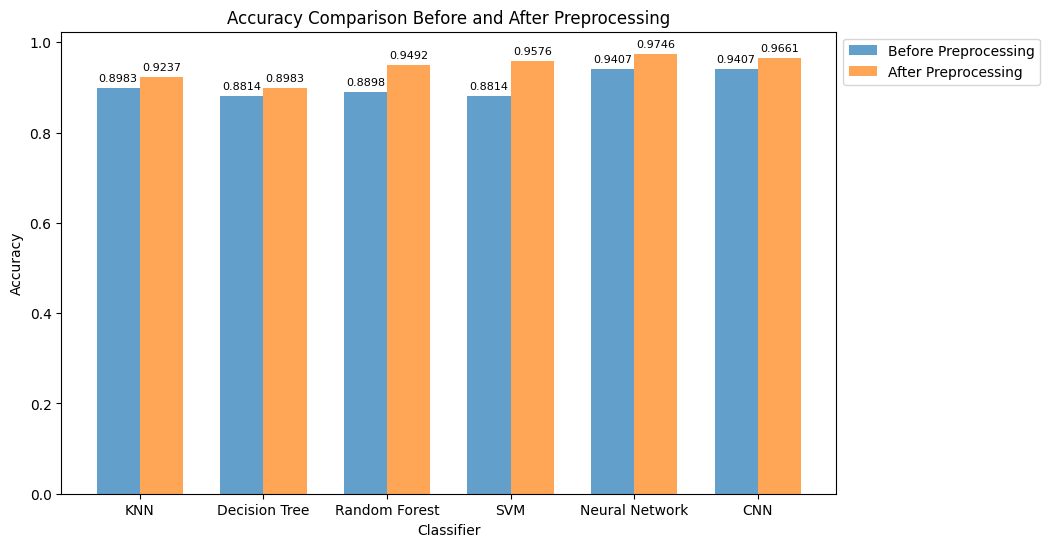

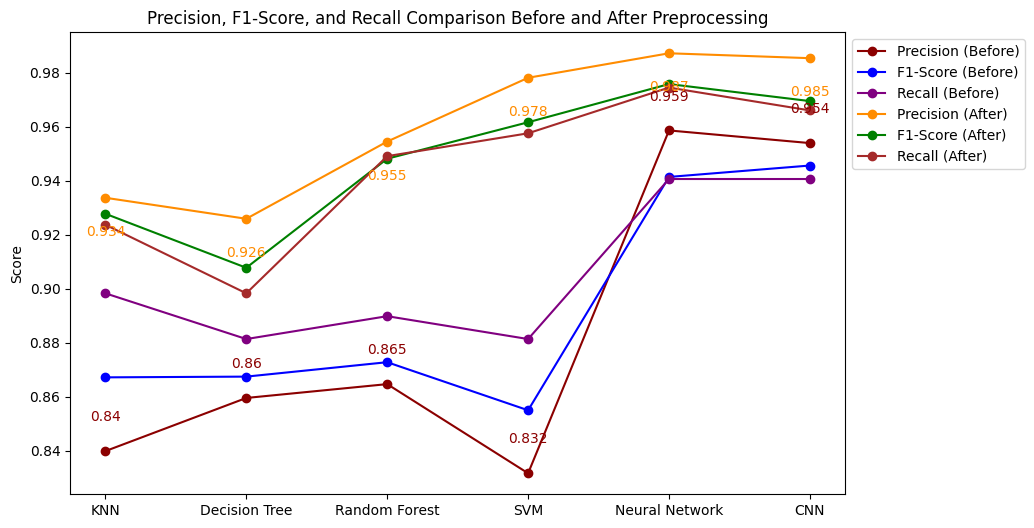

In [930]:
import numpy as np
import matplotlib.pyplot as plt

classifiers_before = ['KNN', 'Decision Tree', 'Random Forest', 'SVM', 'Neural Network', 'CNN']

# Accuracy values
accuracy_values_before = [knn_accuracy_before, dt_accuracy_before, rf_accuracy_before, svm_accuracy_before, nn_accuracy_before, cnn_accuracy_before]

# Precision values
precision_values_before = [knn_precision_before, dt_precision_before, rf_precision_before, svm_precision_before, nn_precision_before, cnn_precision_before]

# Recall values
recall_values_before = [knn_recall_before, dt_recall_before, rf_recall_before, svm_recall_before, nn_recall_before, cnn_recall_before]

# F1 Score values
f1_values_before = [knn_f1_before, dt_f1_before, rf_f1_before, svm_f1_before, nn_f1_before, cnn_f1_before]

classifiers_after = ['KNN', 'Decision Tree', 'Random Forest', 'SVM', 'Neural Network', 'CNN']

# Accuracy values after preprocessing
accuracy_values_after = [knn_accuracy_after, dt_accuracy_after, rf_accuracy_after, svm_accuracy_after, nn_accuracy_after, cnn_accuracy_after]

# Precision values after preprocessing
precision_values_after = [knn_precision_after, dt_precision_after, rf_precision_after, svm_precision_after, nn_precision_after, cnn_precision_after]

# Recall values after preprocessing
recall_values_after = [knn_recall_after, dt_recall_after, rf_recall_after, svm_recall_after, nn_recall_after, cnn_recall_after]

# F1 Score values after preprocessing
f1_values_after = [knn_f1_after, dt_f1_after, rf_f1_after, svm_f1_after, nn_f1_after, cnn_f1_after]

# Print values before preprocessing
print("Before Preprocessing:")
for classifier, accuracy, precision, recall, f1 in zip(classifiers_before, accuracy_values_before, precision_values_before, recall_values_before, f1_values_before):
    print(f"{classifier}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print()

# Print values after preprocessing
print("After Preprocessing:")
for classifier, accuracy, precision, recall, f1 in zip(classifiers_after, accuracy_values_after, precision_values_after, recall_values_after, f1_values_after):
    print(f"{classifier}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print()

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
bar_positions_before = np.arange(len(classifiers_before))
bar_positions_after = bar_positions_before + bar_width

# Before Preprocessing
ax.bar(bar_positions_before, accuracy_values_before, width=bar_width, label='Before Preprocessing', alpha=0.7)

# After Preprocessing
ax.bar(bar_positions_after, accuracy_values_after, width=bar_width, label='After Preprocessing', alpha=0.7)

# Annotate values on bars
for i, (before, after) in enumerate(zip(accuracy_values_before, accuracy_values_after)):
    ax.text(i, before + 0.01, f'{before:.4f}', ha='center', va='bottom', fontsize=8)
    ax.text(i + bar_width, after + 0.01, f'{after:.4f}', ha='center', va='bottom', fontsize=8)

ax.set_title('Accuracy Comparison Before and After Preprocessing')
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy')
ax.set_xticks(bar_positions_before + bar_width / 2)
ax.set_xticklabels(classifiers_before)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plotting Precision, F1-Score, and Recall
fig, ax = plt.subplots(figsize=(10, 6))

# Before Preprocessing
ax.plot(classifiers, precision_values_before, marker='o', label='Precision (Before)', color='darkred')
ax.plot(classifiers, f1_values_before, marker='o', label='F1-Score (Before)', color='blue')
ax.plot(classifiers, recall_values_before, marker='o', label='Recall (Before)', color='purple')

# After Preprocessing
ax.plot(classifiers, precision_values_after, marker='o', label='Precision (After)', color='darkorange')
ax.plot(classifiers, f1_values_after, marker='o', label='F1-Score (After)', color='green')
ax.plot(classifiers, recall_values_after, marker='o', label='Recall (After)', color='brown')

# Annotate values on points
for i, value in enumerate(precision_values_before):
    ax.text(i, value + 0.01, f'{round(value, 3)}', ha='center', va='bottom', color='darkred')

for i, value in enumerate(precision_values_after):
    ax.text(i, value - 0.01, f'{round(value, 3)}', ha='center', va='top', color='darkorange')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylabel('Score')
plt.title('Precision, F1-Score, and Recall Comparison Before and After Preprocessing')
plt.show()

## Conclusion

In evaluating the performance of various classifiers before and after preprocessing on a HCV dataset, several key observations emerge.

### Before Preprocessing:

- **KNN, Decision Tree, Random Forest, SVM, Neural Network, CNN:**
  - The classifiers demonstrated moderate to good performance in accuracy, precision, recall, and F1 score.
  - The results suggest that while these models provided reasonable predictions, there was room for improvement, especially in handling class imbalances and capturing complex patterns in the data.

### After Preprocessing:

- **KNN:**
  - Witnessed a notable improvement in accuracy, precision, recall, and F1 score after preprocessing.
  - Achieved high scores across all metrics, making it a standout performer after data preparation.

- **Decision Tree:**
  - Maintained similar accuracy while showing enhanced precision, recall, and F1 score after preprocessing.
  - Remains a stable choice, particularly considering its interpretability.

- **Random Forest:**
  - Exhibited substantial improvements across all metrics after preprocessing, showcasing its adaptability to cleaner data.
  - Achieved high accuracy and precision, positioning it as a robust performer.

- **SVM:**
  - Displayed improvements in accuracy, precision, recall, and F1 score after preprocessing.
  - Maintained competitive performance, particularly in precision.

- **Neural Network and CNN:**
  - Outperformed other models in terms of accuracy, precision, recall, and F1 score.
  - Demonstrated the capacity to capture complex patterns in the data, especially after preprocessing.

### Overall:

- **Random Forest and SVM** showed substantial improvements after preprocessing, establishing them as robust choices.
- **Neural Network and CNN** demonstrated superior performance, especially in capturing intricate relationships within the data.

### Recommendations:

- For interpretable models, Decision Tree or SVM may be preferred, balancing between performance and transparency.
- For complex relationships, Neural Network or CNN might be more suitable, offering high accuracy and capturing intricate patterns.

These conclusions are based on the specific performance metrics of each classifier, providing insights into their strengths and areas of improvement after preprocessing. The choice of a model depends on the specific requirements of the application, considering factors such as interpretability, performance, and the nature of the dataset.
